In [1]:
# NOTE
# might need further dimension reduction because I'm removing a lot of data by filtering out the 20 subjects

In [2]:
# External libraries for data processing
import numpy as np
import pandas as pd
import sklearn as sk
#To render graphs within notebook
%matplotlib inline
import matplotlib.pyplot as plt
import joblib 
import os

# Versions of libraries
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Scikit version: {}".format(sk.__version__))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

Numpy version: 1.24.3
Pandas version: 1.5.3
Scikit version: 1.3.0


In [3]:
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
path = "C:/Users/jenni/OneDrive/Desktop/IP/LOS_RF_learners/"

# Loading pretrained LOS learners

### labevents

In [5]:
file = "random_forest_labevents.joblib"
full_path = path + file

random_forest_labevents = joblib.load(full_path)

In [6]:
random_forest_labevents

RandomForestRegressor(max_depth=10, random_state=42)

### microbiologyevents

In [7]:
file = "random_forest_microbio.joblib"
full_path = path + file

random_forest_microbio = joblib.load(full_path)

In [8]:
random_forest_microbio

RandomForestRegressor(max_depth=10, random_state=42)

### poe

In [9]:
file = "random_forest_poe.joblib"
full_path = path + file

random_forest_poe = joblib.load(full_path)

In [10]:
random_forest_poe

RandomForestRegressor(max_depth=10, random_state=42)

### poe_detail

In [11]:
file = "random_forest_poe_detail.joblib"
full_path = path + file

random_forest_poe_detail = joblib.load(full_path)

In [12]:
random_forest_poe_detail

RandomForestRegressor(max_depth=10, random_state=42)

### chartevents

In [13]:
# file = "random_forest_chart.joblib"
# full_path = path + file

# random_forest_chart = joblib.load(full_path)

In [14]:
# ENSEMBLE

### procedures_icd

In [15]:
file = "random_forest_procedures.joblib"
full_path = path + file

random_forest_procedures = joblib.load(full_path)

In [16]:
random_forest_procedures

RandomForestRegressor(max_depth=10, random_state=42)

### transfers

In [17]:
file = "random_forest_transfers.joblib"
full_path = path + file

random_forest_transfers = joblib.load(full_path)

In [18]:
random_forest_transfers

RandomForestRegressor(max_depth=10, random_state=42)

### inputevents

In [19]:
file = "random_forest_input.joblib"
full_path = path + file

random_forest_input = joblib.load(full_path)

In [20]:
random_forest_input

RandomForestRegressor(max_depth=10, random_state=42)

### procedureevents

In [21]:
file = "random_forest_procedure_events.joblib"
full_path = path + file

random_forest_procedure_events = joblib.load(full_path)

In [22]:
random_forest_procedure_events

RandomForestRegressor(max_depth=10, random_state=42)

## Load and preprocess evaluation data

In [23]:
folder_name = 'EnsembleEvaluationData'

#### Global functions

In [24]:
def convert_to_days(duration_str):
    parts = duration_str.split(' days ')  # Split string into form ['22', '20:55:00']
    days = float(parts[0])  # Extract number of days and convert to float
    time_parts = parts[1].split(':')  # Split time part (hh:mm:ss) ['20', '55', '00']
    hours = float(time_parts[0])  # Extract hours and convert to float
    minutes = float(time_parts[1])  # Extract minutes and convert to float
    seconds = float(time_parts[2])  # Extract seconds and convert to float
    total_days = days + (hours / 24) + (minutes / (24 * 60)) + (seconds / (24 * 3600))  # Calculate total days
    return total_days

#### Target variable LOS

In [25]:
path = "C:/Project/Data/"

In [26]:
# LOS based on admissions table (target dataframe)

file = "hosp/admissions.csv"
full_path = path + file

df_admissions = pd.read_csv(full_path)

In [27]:
df_admissions['dischtime'] = pd.to_datetime(df_admissions['dischtime'], format='%d/%m/%Y %H:%M')
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'], format='%d/%m/%Y %H:%M')

In [28]:
df_los_hadm = pd.DataFrame()
df_los_subject = pd.DataFrame()

df_los_subject['subject_id'] = df_admissions['subject_id']
df_los_hadm['hadm_id'] = df_admissions['hadm_id']
df_los_hadm['los'] = df_admissions['dischtime']-df_admissions['admittime']
df_los_subject['los'] = df_admissions['dischtime']-df_admissions['admittime']

In [29]:
# Average LOS for each subject_id
df_los_subject = df_los_subject.groupby('subject_id').mean().reset_index()

In [30]:
df_admittime= pd.DataFrame()
df_admittime['hadm_id'] = df_admissions['hadm_id']
df_admittime['admittime'] = df_admissions['admittime']

### labevents

In [31]:
folder_name = 'EnsembleEvaluationData'

In [32]:
file_path = os.path.join(folder_name, 'df_labevents_evaluation.csv')

df_labevents = pd.read_csv(file_path)

#### Preprocessing

In [33]:
df_labevents = df_labevents.reset_index(drop=True)

In [34]:
df_labevents['value'] = pd.to_numeric(df_labevents['value'], errors='coerce').fillna(0)

In [35]:
# Make a feature for days_since_admission using charttime - admittime

# Convert to datetime
df_labevents['charttime'] = pd.to_datetime(df_labevents['charttime'], format='%Y/%m/%d %H:%M')

# Add admittime column from other dataframe
df_labevents = df_labevents.merge(df_admittime, on='hadm_id', how='left')

# # Discard the time part and keep only the date
# df_hcpcsevents['admittime'] = df_hcpcsevents['admittime'].dt.date
# df_hcpcsevents['chartdate'] = df_hcpcsevents['chartdate'].dt.date

df_labevents['days_since_admission'] = df_labevents['charttime'] - df_labevents['admittime']

# Fill any non time values
df_labevents['days_since_admission'] = df_labevents['days_since_admission'].fillna(pd.Timedelta(0))

In [36]:
# Add storetime - charttime feature called delay

# Convert to datetime
df_labevents['storetime'] = pd.to_datetime(df_labevents['storetime'], format='%Y/%m/%d %H:%M')

df_labevents['delay'] = df_labevents['storetime'] - df_labevents['charttime']

# Fill any non time values
df_labevents['delay'] = df_labevents['delay'].fillna(pd.Timedelta(0))

In [37]:
df_labevents = df_labevents.drop(columns=['labevent_id','subject_id','order_provider_id','charttime','storetime','comments'])

In [38]:
# For flag make abnormal = 1 and fill Null with 0
df_labevents['flag'] = df_labevents['flag'].fillna(0)
df_labevents['flag'] = df_labevents['flag'].replace('abnormal', 1)

In [39]:
# For priority fill Null with N/A and then one hot encode
df_labevents['priority'] = df_labevents['priority'].fillna('N/A')
df_labevents = pd.get_dummies(df_labevents, columns=['priority'])

In [40]:
df_labevents = pd.get_dummies(df_labevents, columns=['valueuom','specimen_id','itemid'])

In [41]:
# Drop any rows with null values 
df_labevents = df_labevents.dropna()
# Reduced from 107727 rows to 66660

In [42]:
df_labevents = df_labevents.merge(df_los_hadm, on='hadm_id', how='left')
# df_labevents = df_labevents.drop(columns=['hadm_id', 'admittime'])
df_labevents = df_labevents.drop(columns=['admittime'])

In [43]:
data = df_labevents.drop(columns=['los'])
target = pd.DataFrame(df_labevents['los'])

#### Feature adjusting

In [44]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [45]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'labevents_features.csv')

labevents_features = pd.read_csv(file_path)

In [46]:
labevents_features = labevents_features['Column Names'].tolist()

In [47]:
data = data.drop(columns=[col for col in data.columns if col not in labevents_features])

In [48]:
missing_columns = [col for col in labevents_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\817388605.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [49]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=labevents_features)

#### Testing the learner

In [50]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

target['los'] = target['los'].apply(convert_to_days)
data['delay']= data['delay'].astype(str)
data['delay']= data['delay'].apply(convert_to_days)

In [51]:
# Convert strings to integers
data['days_since_admission'] = data['days_since_admission'].astype(str)
data['days_since_admission'] = data['days_since_admission'].str.split().str[0].astype(int)

In [52]:
target['los'].describe()

count    14111.000000
mean        12.053126
std          7.153748
min          0.502083
25%          6.511111
50%         10.003472
75%         14.078472
max         25.538889
Name: los, dtype: float64

Mean Squared Error: 38.58145548937769


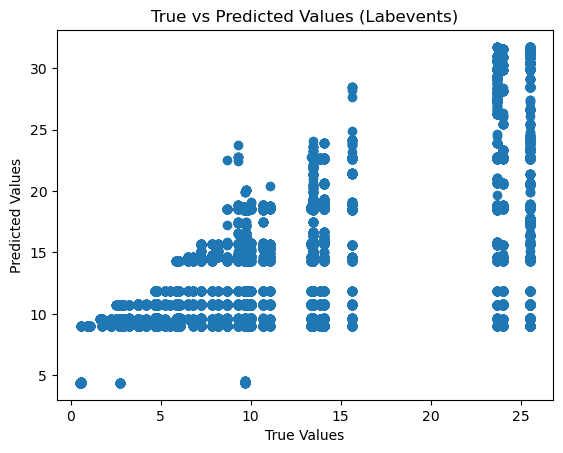

In [53]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_labevents = random_forest_labevents.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_labevents)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_labevents)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Labevents)")
plt.show()

#### Compare to MSE of always guessing average

In [54]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_labevents - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 29.25053177531975


#### Average prediction for each hadm_id

In [55]:
df_labevents_pred = pd.concat([df_labevents, pd.DataFrame(y_pred_labevents,columns=['prediction'])], axis=1)

In [56]:
predictions_labevents = pd.DataFrame()

In [57]:
predictions_labevents['prediction'] = df_labevents_pred.groupby('hadm_id')['prediction'].mean()
predictions_labevents = predictions_labevents.reset_index()

In [58]:
predictions_labevents

hadm_id  prediction
0   20297618.0   14.076868
1   20385771.0   20.516657
2   20611796.0    7.117491
3   21133938.0   11.506541
4   21255400.0   12.124235
5   21477991.0    9.295282
6   21540783.0    9.813154
7   21599196.0    9.181180
8   21607814.0   12.649927
9   22130791.0    9.993791
10  22228639.0    4.389874
11  22413744.0   16.110612
12  22490490.0   11.105549
13  22508257.0   12.784534
14  22585261.0    9.429816
15  23488445.0    9.497009
16  24540843.0   13.078330
17  24656677.0   10.007599
18  24912093.0   12.049966
19  24980601.0    9.913153
20  25020332.0    9.495245
21  25085565.0   14.583400
22  25103777.0   10.907477
23  25508812.0   11.532269
24  25559382.0    8.983604
25  25742920.0    9.316086
26  25922998.0    9.663386
27  25970245.0   10.074626
28  26275841.0   11.507362
29  26706939.0    9.833885
30  26842957.0    9.571841
31  27167814.0   13.408796
32  27259207.0   13.162756
33  27296885.0    9.764557
34  27494880.0    6.341631
35  27553957.0   11.330897
36  27617929.0    9.956798
37  27660781.0   16.531297
38  27703517.0   10.808727
39  27993466.0   10.560566
40  28236161.0    9.010342
41  28335091.0    9.681309
42  28676446.0    9.923343
43  28723315.0    8.983604
44  28829452.0   11.421535
45  28998349.0   17.718728
46  29276678.0   13.626383
47  29279905.0   13.207726
48  29295881.0    9.458150
49  29483621.0   12.104505
50  29858644.0   10.004704
51  29974575.0   14.244049

In [59]:
# Have ended with a final prediction for a particular stay 

### microbiologyevents

In [72]:
folder_name = 'EnsembleEvaluationData'

In [73]:
file_path = os.path.join(folder_name, 'df_microbio_evaluation.csv')

df_microbio = pd.read_csv(file_path)

#### Preprocessing

In [74]:
df_microbio = df_microbio.reset_index(drop=True)

In [75]:
# make days_since_admission using charttime 

# Convert to datetime
df_microbio['charttime'] = pd.to_datetime(df_microbio['charttime'], format='%Y/%m/%d %H:%M')

# Add admittime column from other dataframe
df_microbio = df_microbio.merge(df_admittime, on='hadm_id', how='left')

# # Discard the time part and keep only the date
# df_hcpcsevents['admittime'] = df_hcpcsevents['admittime'].dt.date
# df_hcpcsevents['chartdate'] = df_hcpcsevents['chartdate'].dt.date

df_microbio['days_since_admission'] = df_microbio['charttime'] - df_microbio['admittime']

# Fill any non time values
df_microbio['days_since_admission'] = df_microbio['days_since_admission'].fillna(pd.Timedelta(0))

# Drop the admission time column
df_microbio = df_microbio.drop(columns=['admittime'])

In [76]:
# Add storetime - charttime feature (call it delay)

# Convert to datetime
df_microbio['storetime'] = pd.to_datetime(df_microbio['storetime'], format='%Y/%m/%d %H:%M')

df_microbio['delay'] = df_microbio['storetime'] - df_microbio['charttime']

# Fill any non time values
df_microbio['delay'] = df_microbio['delay'].fillna(pd.Timedelta(0))

In [77]:
# Drop
# spec_itemid , test_itemid
df_microbio = df_microbio.drop(columns=['microevent_id','subject_id','chartdate','charttime','test_seq','storedate',
                                       'storetime','quantity','comments','ab_itemid',
                                       'spec_itemid','test_itemid','org_itemid','micro_specimen_id'])

In [78]:
# Impute null with 0: order_provider_id, org_itemid, isolate_num, ab_itemid, dilution_value
df_microbio['order_provider_id'] = df_microbio['order_provider_id'].fillna(0)
df_microbio['isolate_num'] = df_microbio['isolate_num'].fillna(0)
df_microbio['dilution_value'] = df_microbio['dilution_value'].fillna(0)

In [79]:
# Impute with N/A and then one hot encode: interpretation
# encode test_name, ab_name

df_microbio['interpretation'] = df_microbio['interpretation'].fillna('N/A')
df_microbio['test_name'] = df_microbio['test_name'].fillna('N/A')
df_microbio['ab_name'] = df_microbio['ab_name'].fillna('N/A')
df_microbio['org_name'] = df_microbio['org_name'].fillna('None')
df_microbio = pd.get_dummies(df_microbio, columns=['org_name','interpretation','ab_name','test_name'])

In [80]:
# Keep but categorical: order_provider_id, spec_type_desc, dilution_text, dilution_comparison
df_microbio = pd.get_dummies(df_microbio, columns=['order_provider_id','spec_type_desc','dilution_text',
                                                  'dilution_comparison'])

In [81]:
df_microbio = df_microbio.dropna()

In [82]:
df_microbio = df_microbio.merge(df_los_hadm, on='hadm_id', how='left')
# df_microbio = df_microbio.drop(columns=['hadm_id'])

In [83]:
data = df_microbio.drop(columns=['los'])
target = pd.DataFrame(df_microbio['los'])

#### Feature adjusting

In [84]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [85]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'microbio_features.csv')

microbio_features = pd.read_csv(file_path)

In [86]:
microbio_features = microbio_features['Column Names'].tolist()

In [87]:
data = data.drop(columns=[col for col in data.columns if col not in microbio_features])

In [88]:
missing_columns = [col for col in microbio_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3825752001.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3825752001.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3825752001.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [89]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=microbio_features)

#### Testing the learner

In [90]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

target['los'] = target['los'].apply(convert_to_days)
data['delay']= data['delay'].astype(str)
data['delay']= data['delay'].apply(convert_to_days)
data['days_since_admission'] = data['days_since_admission'].astype(str)
data['days_since_admission'] = data['days_since_admission'].apply(convert_to_days)

In [91]:
target['los'].describe()

count    399.000000
mean      12.918169
std        7.609913
min        1.754167
25%        7.238889
50%       10.003472
75%       15.634722
max       25.538889
Name: los, dtype: float64

Mean Squared Error: 60.897912904397025


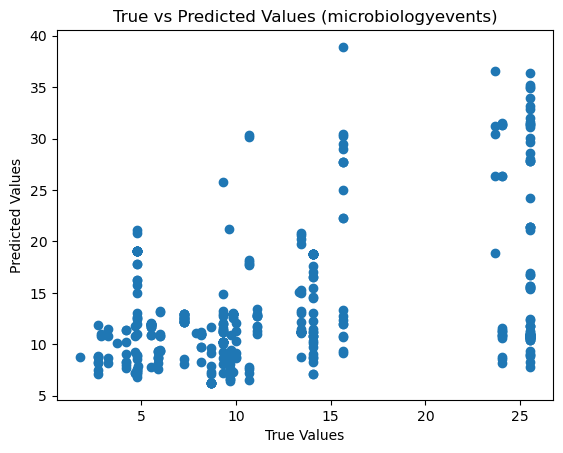

In [92]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_microbio = random_forest_microbio.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_microbio)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_microbio)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (microbiologyevents)")
plt.show()

#### Compare to MSE of always guessing average

In [93]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_microbio - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 46.89644946894706


#### Average prediction for each hadm_id

In [94]:
df_microbio_pred = pd.concat([df_microbio, pd.DataFrame(y_pred_microbio,columns=['prediction'])], axis=1)

In [95]:
predictions_microbio = pd.DataFrame()

In [96]:
predictions_microbio['prediction'] = df_microbio_pred.groupby('hadm_id')['prediction'].mean()
predictions_microbio = predictions_microbio.reset_index()

In [97]:
predictions_microbio

hadm_id  prediction
0   20297618.0   10.193954
1   20385771.0   28.699598
2   21133938.0    7.415772
3   21255400.0   10.026562
4   21540783.0    9.770365
5   21607814.0   15.096531
6   22130791.0    9.249021
7   22413744.0   20.649334
8   22490490.0   12.464034
9   22508257.0   21.239753
10  22585261.0   10.317247
11  23488445.0    9.265684
12  24540843.0   11.296437
13  24656677.0   11.492970
14  25020332.0    8.119894
15  25085565.0   10.488084
16  25103777.0   10.885629
17  25508812.0   12.155291
18  25742920.0    8.741159
19  25922998.0    7.856219
20  26275841.0    7.552660
21  26706939.0   10.131464
22  27167814.0   12.323651
23  27617929.0   14.336821
24  27660781.0   17.201240
25  27703517.0    8.903291
26  27993466.0    7.599999
27  28829452.0   10.409027
28  28998349.0   17.917973
29  29276678.0   13.346785
30  29279905.0   16.138501
31  29295881.0   10.866553
32  29483621.0   11.091848
33  29974575.0   16.741348

In [98]:
# Have ended with a final prediction for a particular stay 

### poe

In [99]:
folder_name = 'EnsembleEvaluationData'

In [100]:
file_path = os.path.join(folder_name, 'df_poe_evaluation.csv')

df_poe = pd.read_csv(file_path)

#### Preprocessing (on training data)

In [101]:
df_poe = df_poe.reset_index(drop=True)

In [102]:
# make a feature of ordertime - admittime for days_since_admission

# Convert to datetime
df_poe['ordertime'] = pd.to_datetime(df_poe['ordertime'], format='%Y/%m/%d %H:%M:%S')

# Add admittime column from other dataframe
df_poe = df_poe.merge(df_admittime, on='hadm_id', how='left')

# # Discard the time part and keep only the date
# df_hcpcsevents['admittime'] = df_hcpcsevents['admittime'].dt.date
# df_hcpcsevents['chartdate'] = df_hcpcsevents['chartdate'].dt.date

df_poe['days_since_admission'] = df_poe['ordertime'] - df_poe['admittime']

# Fill any non time values
df_poe['days_since_admission'] = df_poe['days_since_admission'].fillna(pd.Timedelta(0))

# Drop the admission time column
df_poe = df_poe.drop(columns=['admittime'])

In [103]:
# Drop 
df_poe = df_poe.drop(columns=['poe_id','subject_id','ordertime','discontinue_of_poe_id','discontinued_by_poe_id',
                                       'order_status'])

In [104]:
# Encode
df_poe = pd.get_dummies(df_poe, columns=['order_type','transaction_type'])

In [105]:
# Impute with N/A and encode
df_poe['order_subtype'] = df_poe['order_subtype'].fillna('N/A')
df_poe['order_provider_id'] = df_poe['order_provider_id'].fillna('N/A')
df_poe = pd.get_dummies(df_poe, columns=['order_subtype','order_provider_id'])

In [106]:
df_poe = df_poe.merge(df_los_hadm, on='hadm_id', how='left')
# df_poe = df_poe.drop(columns=['hadm_id'])

In [107]:
data = df_poe.drop(columns=['los'])
target = pd.DataFrame(df_poe['los'])

#### Feature adjusting

In [108]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [109]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'poe_features.csv')

poe_features = pd.read_csv(file_path)

In [110]:
poe_features = poe_features['Column Names'].tolist()

In [111]:
data = data.drop(columns=[col for col in data.columns if col not in poe_features])

In [112]:
missing_columns = [col for col in poe_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\254992019.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [113]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=poe_features)

#### Testing the learner

In [114]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

target['los'] = target['los'].apply(convert_to_days)
data['days_since_admission'] = data['days_since_admission'].astype(str)
data['days_since_admission'] = data['days_since_admission'].apply(convert_to_days)

In [115]:
target['los'].describe()

count    9125.000000
mean       10.540197
std         6.671301
min         0.502083
25%         5.266667
50%         9.706944
75%        13.451389
max        25.538889
Name: los, dtype: float64

Mean Squared Error: 44.89160586853985


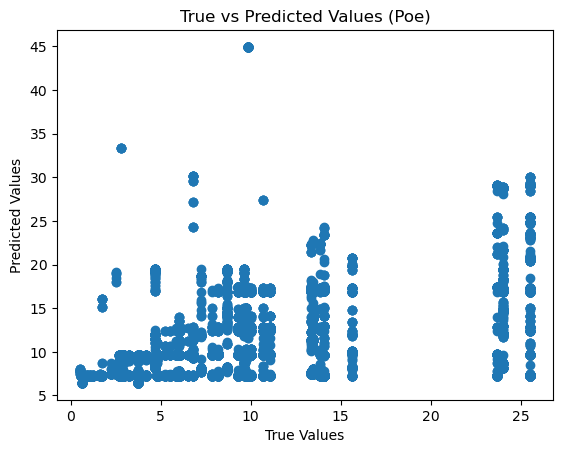

In [116]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_poe = random_forest_poe.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_poe)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_poe)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Poe)")
plt.show()

#### Compare to MSE of always guessing average

In [117]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_poe - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 30.343125677233925


#### Average prediction for each hadm_id

In [118]:
df_poe_pred = pd.concat([df_poe, pd.DataFrame(y_pred_poe,columns=['prediction'])], axis=1)

In [119]:
predictions_poe = pd.DataFrame()

In [120]:
predictions_poe['prediction'] = df_poe_pred.groupby('hadm_id')['prediction'].mean()
predictions_poe = predictions_poe.reset_index()

In [121]:
predictions_poe

hadm_id  prediction
0   20282368    7.942384
1   20297618   12.022624
2   20385771   15.001219
3   20611796    7.551078
4   20900955    6.435246
5   21133938   12.154776
6   21255400   11.196730
7   21477991    8.861636
8   21540783    7.895647
9   21599196    7.539364
10  21607814   12.412270
11  22130791   11.226758
12  22228639    7.763563
13  22413744   12.309987
14  22490490   21.842605
15  22508257   12.024626
16  22585261    7.919794
17  23488445    7.581990
18  24540843   11.250665
19  24656677    7.794503
20  24912093    8.625367
21  24980601    7.003034
22  25020332    7.886439
23  25085565   10.967510
24  25103777    9.128964
25  25508812   11.905388
26  25559382    7.290349
27  25742920    8.575768
28  25922998    7.527113
29  25970245    8.516547
30  26275841   10.298478
31  26706939    7.815114
32  26842957    7.303220
33  27167814   10.485877
34  27259207   11.675868
35  27296885    9.199744
36  27494880    7.270591
37  27553957   12.229326
38  27617929    8.466595
39  27660781   16.599831
40  27703517    8.377535
41  27993466    8.448108
42  28236161    7.741345
43  28335091    7.904462
44  28676446    8.528836
45  28723315    7.282514
46  28778757    7.290349
47  28829452    9.334307
48  28998349   15.139993
49  29276678   13.201306
50  29279905   10.444315
51  29295881    7.616707
52  29483621    9.092036
53  29858644    7.883343
54  29974575   12.053213

In [122]:
# Have ended with a final prediction for a particular stay 

### poe_detail

In [123]:
folder_name = 'EnsembleEvaluationData'

In [124]:
file_path = os.path.join(folder_name, 'df_poe_detail_evaluation.csv')

df_poe_detail = pd.read_csv(file_path)

#### Preprocessing

In [125]:
df_poe_detail = df_poe_detail.reset_index(drop=True)

In [126]:
# Drop 
df_poe_detail = df_poe_detail.drop(columns=['poe_id'])

In [127]:
# Encode
df_poe_detail = pd.get_dummies(df_poe_detail, columns=['field_name','field_value'])

In [128]:
df_poe_detail = df_poe_detail.merge(df_los_subject, on='subject_id', how='left')
# df_poe_detail = df_poe_detail.drop(columns=['subject_id'])

In [129]:
data = df_poe_detail.drop(columns=['los'])
target = pd.DataFrame(df_poe_detail['los'])

#### Feature adjusting

In [130]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [131]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'poe_detail_features.csv')

poe_detail_features = pd.read_csv(file_path)

In [132]:
poe_detail_features = poe_detail_features['Column Names'].tolist()

In [133]:
data = data.drop(columns=[col for col in data.columns if col not in poe_detail_features])

In [134]:
missing_columns = [col for col in poe_detail_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

In [135]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=poe_detail_features)

#### Testing the learner

In [136]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

target['los'] = target['los'].apply(convert_to_days)

In [137]:
target['los'].describe()

count    2153.000000
mean        7.432417
std         3.271030
min         1.444444
25%         4.724306
50%         6.586736
75%         9.781250
max        14.060417
Name: los, dtype: float64

Mean Squared Error: 15.527863871950679


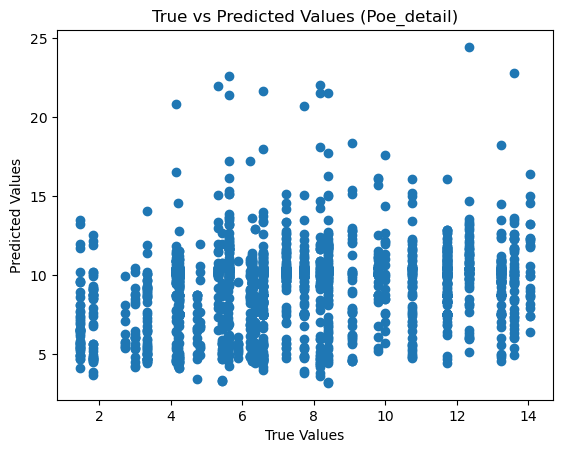

In [138]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_poe_detail = random_forest_poe_detail.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_poe_detail)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_poe_detail)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Poe_detail)")
plt.show()

#### Compare to MSE of always guessing average

In [139]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_poe_detail - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 9.206688405971388


#### Average prediction for each hadm_id

In [140]:
df_poe_detail = pd.concat([df_poe_detail, pd.DataFrame(y_pred_poe_detail,columns=['prediction'])], axis=1)

In [141]:
predictions_poe_detail = pd.DataFrame()

In [142]:
predictions_poe_detail['prediction'] = df_poe_detail.groupby('subject_id')['prediction'].mean()
predictions_poe_detail = predictions_poe_detail.reset_index()

In [143]:
predictions_poe_detail

subject_id  prediction
0     10000032    7.027282
1     10001217    7.175853
2     10002428   10.785486
3     10002930    7.285365
4     10003400    9.566458
5     10004235   10.538489
6     10004422   10.137819
7     10004457    7.447628
8     10005866    9.945286
9     10014354    8.228640
10    10015272    6.230567
11    10015860    9.371458
12    10015931    9.514593
13    10018328    8.186885
14    10019003    9.690264
15    10019172    6.919345
16    10019385    8.261581
17    10019917    6.601597
18    10020187    6.411839
19    10020306    9.278893
20    10020786    6.751019
21    10020944   10.748911
22    10021312    6.868547
23    10021487   10.481594
24    10023117   10.092597
25    10023239    6.761212
26    10027445   10.184492
27    10027602   10.006485
28    10035631    9.660564
29    10037861    9.046553
30    10037928    9.605976
31    10037975    7.605968
32    10040025    9.042923

In [144]:
# Have ended with a final prediction for a particular person

### chartevents

In [145]:
folder_name = 'EnsembleEvaluationData'

In [146]:
file_path = os.path.join(folder_name, 'df_chart_evaluation.csv')

df_chart = pd.read_csv(file_path)

#### Preprocessing

In [147]:
df_chart = df_chart.reset_index(drop=True)

In [148]:
# Make a days_since_admission feature of charttime-admittime 

# Convert to datetime
df_chart['charttime'] = pd.to_datetime(df_chart['charttime'], format='%Y-%m-%d %H:%M:%S')

# Add admittime column from other dataframe
df_chart = df_chart.merge(df_admittime, on='hadm_id', how='left')

# # Discard the time part and keep only the date
# df_hcpcsevents['admittime'] = df_hcpcsevents['admittime'].dt.date
# df_hcpcsevents['chartdate'] = df_hcpcsevents['chartdate'].dt.date

df_chart['days_since_admission'] = df_chart['charttime'] - df_chart['admittime']

# Fill any non time values
df_chart['days_since_admission'] = df_chart['days_since_admission'].fillna(pd.Timedelta(0))

# Drop the admission time column
df_chart = df_chart.drop(columns=['admittime'])

In [149]:
# Make a delay feature of storetime-charttime

# Convert to datetime
df_chart['storetime'] = pd.to_datetime(df_chart['storetime'], format='%Y-%m-%d %H:%M:%S')

df_chart['delay'] = df_chart['storetime'] - df_chart['charttime']

# Fill any non time values
df_chart['delay'] = df_chart['delay'].fillna(pd.Timedelta(0))

In [150]:
# Drop 
df_chart = df_chart.drop(columns=['subject_id','charttime','storetime', 'stay_id','caregiver_id'])

In [151]:
# Impute with N/A and encode
df_chart['valueuom'] = df_chart['valueuom'].fillna('N/A')
df_chart = pd.get_dummies(df_chart, columns=['valueuom','value','itemid'])

In [152]:
# Impute with 0
df_chart['valuenum'] = df_chart['valuenum'].fillna(0)
df_chart['warning'] = df_chart['warning'].fillna(0)

In [153]:
df_chart = df_chart.merge(df_los_hadm, on='hadm_id', how='left')
df_chart = df_chart.drop(columns=['hadm_id'])

#### Testing the learner

In [154]:
# Converting duration strings to floats

df_chart['los'] = df_chart['los'].astype(str)
# df_chart.fillna(0, inplace=True)
df_chart.loc[~df_chart['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

df_chart['los'] = df_chart['los'].apply(convert_to_days)
df_chart['delay']= df_chart['delay'].astype(str)
df_chart['delay']= df_chart['delay'].apply(convert_to_days)
df_chart['days_since_admission'] = df_chart['days_since_admission'].astype(str)
df_chart['days_since_admission'] = df_chart['days_since_admission'].apply(convert_to_days)

In [155]:
# # To combine the models

# # Combine the predictions from all trained models
# def combine_predictions(models, X):
#     predictions = np.zeros((X.shape[0], len(models)))
#     for i, model in enumerate(models):
#         predictions[:, i] = model.predict(X)
#     return np.mean(predictions, axis=1)

# # Assuming your data for prediction is in a DataFrame named test_df
# # You can replace this with your actual DataFrame
# # test_df = ...

# # Combine predictions from all trained models
# combined_predictions = combine_predictions(trained_models, test_df.drop(columns=['target_column']))

# # Final prediction is the average of predictions from all models
# final_prediction = np.mean(combined_predictions)

# print("Final prediction:", final_prediction)

In [156]:
# target['los'].describe()

In [157]:
# # Convert DataFrame to 1D array using ravel()
# target = target.values.ravel()

# # Predict on the test set
# y_pred = random_forest_.predict(data)

# # Calculate mean squared error
# mse = mean_squared_error(target, y_pred)
# print("Mean Squared Error:", mse)

# # Plot true vs predicted values
# plt.scatter(target, y_pred)
# plt.xlabel("True Values")
# plt.ylabel("Predicted Values")
# plt.title("True vs Predicted Values (chartevents)")
# plt.show()

#### Compare to MSE of always guessing average

In [158]:
# # Calculate the mean value of training set target variable
# mean_prediction = np.mean(target)

# # Generate an array of the same length as pred_values with the mean value
# mean_guesses = np.full_like(target, mean_prediction)

# # Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
# mse = np.mean((y_pred - mean_guesses) ** 2)

# print("Mean Squared Error (MSE):", mse)

### procedures_icd

In [159]:
folder_name = 'EnsembleEvaluationData'

In [160]:
file_path = os.path.join(folder_name, 'df_procedures_evaluation.csv')

df_procedures = pd.read_csv(file_path)

#### Preprocessing

In [161]:
df_procedures = df_procedures.reset_index(drop=True)

In [162]:
# make a feature called days_since_admission of chartdate - admitdate

# Convert to datetime
df_procedures['chartdate'] = pd.to_datetime(df_procedures['chartdate'], format='%Y-%m-%d')

# Add admittime column from other dataframe
df_procedures = df_procedures.merge(df_admittime, on='hadm_id', how='left')

# # Discard the time part and keep only the date
df_procedures['admittime'] = df_procedures['admittime'].dt.date
df_procedures['chartdate'] = df_procedures['chartdate'].dt.date

df_procedures['days_since_admission'] = df_procedures['chartdate'] - df_procedures['admittime']

# Fill any non time values
df_procedures['days_since_admission'] = df_procedures['days_since_admission'].fillna(pd.Timedelta(0))

# Drop the admission time column
df_procedures = df_procedures.drop(columns=['admittime'])

In [163]:
# Drop 
df_procedures = df_procedures.drop(columns=['subject_id','chartdate'])

In [164]:
# Encode
df_procedures = pd.get_dummies(df_procedures, columns=['icd_code'])

In [165]:
df_procedures = df_procedures.merge(df_los_hadm, on='hadm_id', how='left')
# df_procedures = df_procedures.drop(columns=['hadm_id'])

In [166]:
data = df_procedures.drop(columns=['los'])
target = pd.DataFrame(df_procedures['los'])

#### Feature adjusting

In [167]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [168]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'procedures_features.csv')

procedures_features = pd.read_csv(file_path)

In [169]:
procedures_features = procedures_features['Column Names'].tolist()

In [170]:
data = data.drop(columns=[col for col in data.columns if col not in procedures_features])

In [171]:
missing_columns = [col for col in procedures_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3137982604.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3137982604.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column] = 0
C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\3137982604.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [172]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=procedures_features)

#### Dimensionality reduction

In [173]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'
target['los'] = target['los'].astype(str)
target['los'] = target['los'].apply(convert_to_days)
data['days_since_admission'] = data['days_since_admission'].astype(str)
data['days_since_admission'] = data['days_since_admission'].str.split().str[0].astype(int)

In [174]:
# Need to reduce from 355 to 115

from sklearn.decomposition import TruncatedSVD

# Number of desired features (components)
n_components = 115

# Initialize Truncated SVD with the desired number of components
svd = TruncatedSVD(n_components=n_components)

# Fit the Truncated SVD model to the sparse matrix and transform the data
svd.fit(data)
data = svd.transform(data)

# Get the explained variance ratio (how much variance is explained by each component)
explained_variance_ratio = svd.explained_variance_ratio_

# Print the transformed matrix and explained variance ratio
# print("Transformed Matrix:")
# print(transformed_matrix)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)

print("\n Amount of original variance conserved:", np.sum(svd.explained_variance_ratio_))


Explained Variance Ratio:
[1.37272242e-01 5.47504485e-01 2.88459680e-01 1.58300695e-03
 1.51934112e-03 1.25739993e-03 9.61114893e-04 9.61114893e-04
 9.61114893e-04 9.45890489e-04 9.29064168e-04 8.25048930e-04
 6.40736271e-04 6.40743202e-04 6.40720732e-04 6.40740942e-04
 6.40741767e-04 6.40734096e-04 6.40741372e-04 6.29219552e-04
 6.16858726e-04 5.39641767e-04 3.20355302e-04 3.20361582e-04
 3.20367322e-04 3.20366099e-04 3.20367886e-04 3.20371606e-04
 3.20363252e-04 3.20369631e-04 3.20371278e-04 3.20354615e-04
 3.20370945e-04 3.20370560e-04 3.20371079e-04 3.20367192e-04
 3.20354882e-04 3.20371558e-04 3.20364274e-04 3.20370991e-04
 3.20360681e-04 3.20368579e-04 3.20370730e-04 3.20333446e-04
 3.20371455e-04 3.20369456e-04 3.20369255e-04 3.20363419e-04
 3.20368701e-04 3.20365852e-04 3.20365601e-04 3.20363218e-04
 3.20371622e-04 2.41551656e-04 1.97212387e-04 1.79522676e-04
 5.71627327e-35 2.50884338e-35 4.04613766e-35 6.17723667e-35
 7.92037801e-35 6.42292826e-35 2.81621084e-35 4.07049113e-

#### Testing the learner

In [175]:
target['los'].describe()

count    152.000000
mean      10.878915
std        7.174094
min        1.222222
25%        5.266667
50%        9.310417
75%       13.829861
max       25.538889
Name: los, dtype: float64

Mean Squared Error: 75.96641138682897


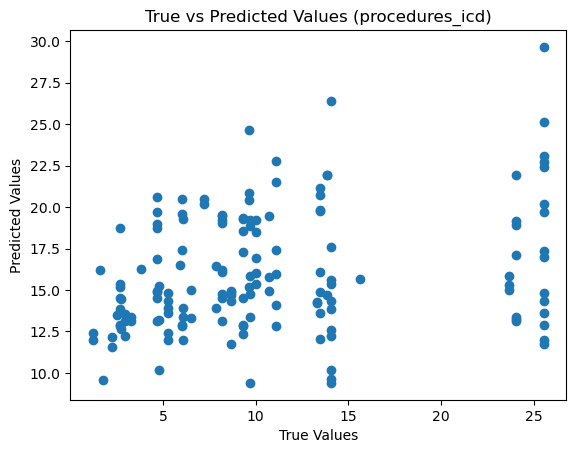

In [176]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_procedures = random_forest_procedures.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_procedures)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_procedures)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (procedures_icd)")
plt.show()

#### Compare to MSE of always guessing average

In [177]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_procedures - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 38.99315680234787


#### Average prediction for each hadm_id

In [178]:
df_procedures_pred = pd.concat([df_procedures, pd.DataFrame(y_pred_procedures,columns=['prediction'])], axis=1)

In [179]:
predictions_procedures = pd.DataFrame()

In [180]:
predictions_procedures['prediction'] = df_procedures_pred.groupby('hadm_id')['prediction'].mean()
predictions_procedures = predictions_procedures.reset_index()

In [181]:
predictions_procedures

hadm_id  prediction
0   20297618   19.039440
1   20385771   15.376163
2   21133938   14.110954
3   21255400   17.210178
4   21477991   14.644581
5   21540783   13.253562
6   21599196   11.859934
7   21607814   14.220414
8   22130791   16.912253
9   22413744   15.667239
10  22508257   20.275282
11  22585261   13.550039
12  24540843   15.879666
13  24912093   14.170438
14  25020332   14.763913
15  25085565   15.998602
16  25103777   16.641269
17  25508812   20.322194
18  25742920    9.582653
19  25970245   13.515049
20  26275841   13.344173
21  26842957   16.232001
22  27167814   17.439660
23  27259207   19.533755
24  27617929   12.873670
25  27660781   16.688074
26  27703517   16.490349
27  28236161   16.276740
28  28335091   12.959096
29  28676446   13.514004
30  28778757   12.206129
31  28829452   16.875711
32  28998349   18.440648
33  29276678   17.247188
34  29279905   16.717483
35  29483621   15.170010
36  29974575   12.228860

In [182]:
# Have ended with a final prediction for a particular stay 

### transfers

In [183]:
folder_name = 'EnsembleEvaluationData'

In [184]:
file_path = os.path.join(folder_name, 'df_transfers_evaluation.csv')

df_transfers = pd.read_csv(file_path)

#### Preprocessing

In [185]:
df_transfers = df_transfers.reset_index(drop=True)

In [186]:
# Make a days_since_admission feature of intime-admittime

# Convert to datetime
df_transfers['intime'] = pd.to_datetime(df_transfers['intime'], format='%Y-%m-%d %H:%M:%S')

# Add admittime column from other dataframe
df_transfers = df_transfers.merge(df_admittime, on='hadm_id', how='left')

df_transfers['days_since_admission'] = df_transfers['intime'] - df_transfers['admittime']

# Fill any non time values
df_transfers['days_since_admission'] = df_transfers['days_since_admission'].fillna(pd.Timedelta(0))

# Drop the admission time column
df_transfers = df_transfers.drop(columns=['admittime'])

In [187]:
# Make a duration feature of outtime-intime 

# Convert to datetime
df_transfers['outtime'] = pd.to_datetime(df_transfers['outtime'], format='%Y-%m-%d %H:%M:%S')

df_transfers['duration'] = df_transfers['outtime'] - df_transfers['intime']

# Fill any non time values
df_transfers['duration'] = df_transfers['duration'].fillna(pd.Timedelta(0))

In [188]:
# Drop 
df_transfers = df_transfers.drop(columns=['subject_id','transfer_id','intime','outtime'])

In [189]:
# Impute with N/A and encode
df_transfers['careunit'] = df_transfers['careunit'].fillna('N/A')
df_transfers = pd.get_dummies(df_transfers, columns=['eventtype','careunit'])

In [190]:
df_transfers = df_transfers.merge(df_los_hadm, on='hadm_id', how='left')
# df_transfers = df_transfers.drop(columns=['hadm_id'])

In [191]:
data = df_transfers.drop(columns=['los'])
target = pd.DataFrame(df_transfers['los'])

In [192]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'

target['los'] = target['los'].apply(convert_to_days)
data['duration']= data['duration'].astype(str)
data['duration']= data['duration'].apply(convert_to_days)
data['days_since_admission'] = data['days_since_admission'].astype(str)
data['days_since_admission'] = data['days_since_admission'].apply(convert_to_days)

#### Feature adjusting

In [193]:
# Need to delete any columns not present in labevents_features 
# Add any from labevents_features and fill with zeroes 

In [194]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'transfers_features.csv')

transfers_features = pd.read_csv(file_path)

In [195]:
transfers_features = transfers_features['Column Names'].tolist()

In [196]:
data = data.drop(columns=[col for col in data.columns if col not in transfers_features])

In [197]:
missing_columns = [col for col in transfers_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

In [198]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=transfers_features)

#### Testing the learner

In [199]:
target['los'].describe()

count    207.000000
mean       7.447078
std        5.712635
min        0.502083
25%        2.919444
50%        5.914583
75%        9.859722
max       25.538889
Name: los, dtype: float64

Mean Squared Error: 18.324764374538972


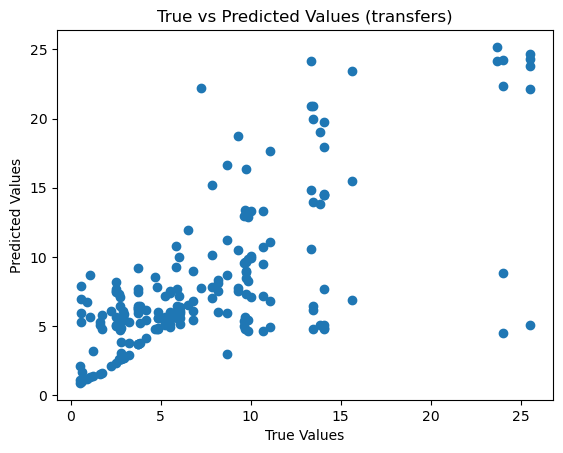

In [200]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_transfers = random_forest_transfers.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_transfers)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_transfers)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (transfers)")
plt.show()

#### Compare to MSE of always guessing average

In [201]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_transfers - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 29.70968009219355


#### Average prediction for each hadm_id

In [202]:
df_transfers_pred = pd.concat([df_transfers, pd.DataFrame(y_pred_transfers,columns=['prediction'])], axis=1)

In [203]:
predictions_transfers = pd.DataFrame()

In [204]:
predictions_transfers['prediction'] = df_transfers_pred.groupby('hadm_id')['prediction'].mean()
predictions_transfers = predictions_transfers.reset_index()

In [205]:
predictions_transfers

hadm_id  prediction
0   20282368.0    2.802644
1   20297618.0    9.952216
2   20385771.0   24.680633
3   20611796.0    4.987772
4   20900955.0    1.258569
5   21133938.0    9.088855
6   21255400.0   10.099183
7   21477991.0    5.824861
8   21540783.0    4.001326
9   21599196.0    4.103725
10  21607814.0   17.624770
11  22130791.0    6.676089
12  22228639.0    1.359861
13  22413744.0   15.258040
14  22490490.0    8.214975
15  22508257.0    8.224226
16  22585261.0    4.601867
17  23488445.0    5.240585
18  24540843.0   11.131541
19  24656677.0    6.090916
20  24912093.0    9.226338
21  24980601.0    6.338065
22  25020332.0    4.970554
23  25085565.0    9.952461
24  25103777.0    7.684177
25  25508812.0   14.993249
26  25559382.0    3.980499
27  25742920.0    4.070062
28  25922998.0    5.368515
29  25970245.0    5.650407
30  26275841.0    8.375196
31  26706939.0    5.846135
32  26842957.0    3.986625
33  27167814.0   10.113449
34  27259207.0   12.645723
35  27296885.0    4.197667
36  27494880.0    5.411381
37  27553957.0    6.809725
38  27617929.0    6.317998
39  27660781.0   14.989565
40  27703517.0    6.283490
41  27993466.0    7.246450
42  28236161.0    5.146612
43  28335091.0    4.664574
44  28676446.0    6.118634
45  28723315.0    5.216902
46  28778757.0    2.299193
47  28829452.0    7.502406
48  28998349.0   20.005641
49  29276678.0   12.043051
50  29279905.0    9.066825
51  29295881.0    4.797860
52  29483621.0   10.059882
53  29858644.0    5.941164
54  29974575.0   13.439182

In [206]:
# Have ended with a final prediction for a particular stay 

### inputevents

In [207]:
folder_name = 'EnsembleEvaluationData'

In [208]:
file_path = os.path.join(folder_name, 'df_input_evaluation.csv')

df_input = pd.read_csv(file_path)

#### Preprocessing 

In [209]:
df_input = df_input.reset_index(drop=True)

In [210]:
# Make a duration feature using endtime-starttime

# Convert to datetime
df_input['endtime'] = pd.to_datetime(df_input['endtime'], format='%Y-%m-%d %H:%M:%S')
df_input['starttime'] = pd.to_datetime(df_input['starttime'], format='%Y-%m-%d %H:%M:%S')


df_input['duration'] = df_input['endtime'] - df_input['starttime']

# Fill any non time values
df_input['duration'] = df_input['duration'].fillna(pd.Timedelta(0))

In [211]:
# Make a recording_delay feature using storetime-endtime

# Convert to datetime
df_input['storetime'] = pd.to_datetime(df_input['storetime'], format='%Y-%m-%d %H:%M:%S')

df_input['recording_delay'] = df_input['storetime'] - df_input['endtime']

# Fill any non time values
df_input['recording_delay'] = df_input['recording_delay'].fillna(pd.Timedelta(0))

In [212]:
# Drop 
df_input = df_input.drop(columns=['subject_id','stay_id','starttime','endtime','storetime','orderid','linkorderid',
                                  'continueinnextdept','totalamountuom', 'stay_id','caregiver_id'])

In [213]:
# Impute with N/A and encode
df_input['rateuom'] = df_input['rateuom'].fillna('N/A')
df_input['secondaryordercategoryname'] = df_input['secondaryordercategoryname'].fillna('N/A')
df_input = pd.get_dummies(df_input, columns=['rateuom','secondaryordercategoryname','amountuom','ordercategoryname',
                                            'ordercomponenttypedescription','ordercategorydescription','statusdescription',
                                            'itemid'])

In [214]:
# Impute with 0
df_input['rate'] = df_input['rate'].fillna(0)
df_input['totalamount'] = df_input['totalamount'].fillna(0)

In [215]:
df_input = df_input.dropna()

In [216]:
df_input = df_input.merge(df_los_hadm, on='hadm_id', how='left')
# df_input = df_input.drop(columns=['hadm_id'])

In [217]:
data = df_input.drop(columns=['los'])
target = pd.DataFrame(df_input['los'])

In [218]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'
target['los'] = target['los'].apply(convert_to_days)
data['duration']= data['duration'].astype(str)
data['duration']= data['duration'].apply(convert_to_days)
data['recording_delay']= data['recording_delay'].astype(str)
data['recording_delay']= data['recording_delay'].apply(convert_to_days)

#### Feature adjusting

In [219]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'input_features.csv')

input_features = pd.read_csv(file_path)

In [220]:
input_features = input_features['Column Names'].tolist()

In [221]:
data = data.drop(columns=[col for col in data.columns if col not in input_features])

In [222]:
missing_columns = [col for col in input_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

In [223]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=input_features)

#### Testing the learner

In [224]:
target['los'].describe()

count    5141.000000
mean       13.110212
std         6.884194
min         1.625000
25%         9.310417
50%        10.704861
75%        14.060417
max        25.538889
Name: los, dtype: float64

Mean Squared Error: 95.69065000663969


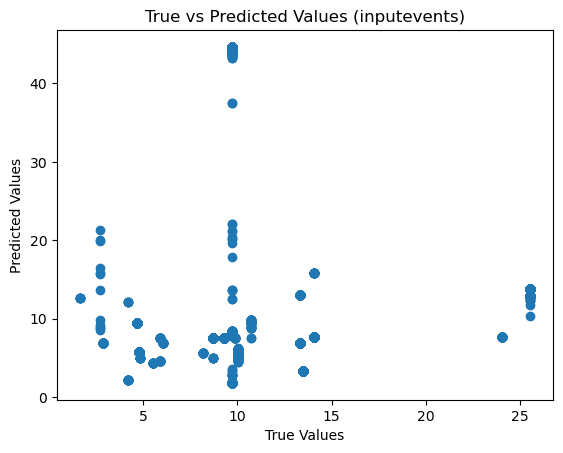

In [225]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_input = random_forest_input.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_input)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_input)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (inputevents)")
plt.show()

#### Compare to MSE of always guessing average

In [226]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_input - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 71.0469272880416


#### Average prediction for each hadm_id

In [227]:
df_input_pred = pd.concat([df_input, pd.DataFrame(y_pred_input,columns=['prediction'])], axis=1)

In [228]:
predictions_input = pd.DataFrame()

In [229]:
predictions_input['prediction'] = df_input_pred.groupby('hadm_id')['prediction'].mean()
predictions_input = predictions_input.reset_index()

In [230]:
predictions_input

hadm_id  prediction
0   20297618    3.570473
1   21133938    7.500904
2   21255400    5.375197
3   21477991    6.930142
4   21607814    8.577696
5   22130791    9.447917
6   22490490    7.562500
7   22585261   14.029027
8   23488445    3.602624
9   24540843    7.538800
10  24656677    4.317756
11  25085565   15.862500
12  25922998    5.024344
13  26275841   42.410790
14  26842957   12.662500
15  27617929    5.813889
16  27660781    7.647917
17  27703517    7.538800
18  27993466    4.652083
19  28829452    5.600000
20  28998349   13.645920
21  29276678    3.308333
22  29279905    9.580032
23  29295881    6.929749
24  29974575    7.647917

In [231]:
# Have ended with a final prediction for a particular stay 

### procedureevents

In [232]:
folder_name = 'EnsembleEvaluationData'

In [233]:
file_path = os.path.join(folder_name, 'df_procedure_events_evaluation.csv')

df_procedure_events = pd.read_csv(file_path)

#### Preprocessing 

In [234]:
df_procedure_events = df_procedure_events.reset_index(drop=True)

In [235]:
# Make a duration feature using endtime-starttime

# Convert to datetime
df_procedure_events['endtime'] = pd.to_datetime(df_procedure_events['endtime'], format='%Y-%m-%d %H:%M:%S')
df_procedure_events['starttime'] = pd.to_datetime(df_procedure_events['starttime'], format='%Y-%m-%d %H:%M:%S')


df_procedure_events['duration'] = df_procedure_events['endtime'] - df_procedure_events['starttime']

# Fill any non time values
df_procedure_events['duration'] = df_procedure_events['duration'].fillna(pd.Timedelta(0))

In [236]:
# Make a recording_delay feature using storetime-endtime

# Convert to datetime
df_procedure_events['storetime'] = pd.to_datetime(df_procedure_events['storetime'], format='%Y-%m-%d %H:%M:%S')

df_procedure_events['recording_delay'] = df_procedure_events['storetime'] - df_procedure_events['endtime']

# Fill any non time values
df_procedure_events['recording_delay'] = df_procedure_events['recording_delay'].fillna(pd.Timedelta(0))

In [237]:
# Drop 
df_procedure_events = df_procedure_events.drop(columns=['subject_id','stay_id','starttime','endtime','storetime','orderid',
                                                        'linkorderid','continueinnextdept','caregiver_id'])

In [238]:
# Impute with N/A and encode
df_procedure_events['location'] = df_procedure_events['location'].fillna('N/A')
df_procedure_events['locationcategory'] = df_procedure_events['locationcategory'].fillna('N/A')
df_procedure_events = pd.get_dummies(df_procedure_events, columns=['location','locationcategory','valueuom',
                                                                   'ordercategoryname','ordercategorydescription',
                                                                   'statusdescription','itemid'])

In [239]:
df_procedure_events = df_procedure_events.merge(df_los_hadm, on='hadm_id', how='left')
# df_procedure_events = df_procedure_events.drop(columns=['hadm_id'])

In [240]:
data = df_procedure_events.drop(columns=['los'])
target = pd.DataFrame(df_procedure_events['los'])

In [241]:
# Converting duration strings to floats

target['los'] = target['los'].astype(str)
target.fillna(0, inplace=True)
target.loc[~target['los'].str.contains('days'), 'los'] = '0 days 00:00:00'
target['los'] = target['los'].apply(convert_to_days)
data['duration']= data['duration'].astype(str)
data['duration']= data['duration'].apply(convert_to_days)
data['recording_delay']= data['recording_delay'].astype(str)
data['recording_delay']= data['recording_delay'].apply(convert_to_days)

#### Feature adjusting

In [242]:
# Features seen in training

folder_name = 'LOS_RF_features'

file_path = os.path.join(folder_name, 'procedure_events_features.csv')

procedure_events_features = pd.read_csv(file_path)

In [243]:
procedure_events_features = procedure_events_features['Column Names'].tolist()

In [244]:
data = data.drop(columns=[col for col in data.columns if col not in procedure_events_features])

In [245]:
missing_columns = [col for col in procedure_events_features if col not in data.columns]

for column in missing_columns:
    data[column] = 0
#     data = data.copy()

In [246]:
# Reorder the columns of the DataFrame
data = data.reindex(columns=procedure_events_features)

#### Testing the learner

In [247]:
target['los'].describe()

count    292.000000
mean      13.294906
std        7.500005
min        1.625000
25%        8.688194
50%       10.003472
75%       14.078472
max       25.538889
Name: los, dtype: float64

Mean Squared Error: 89.87211261963935


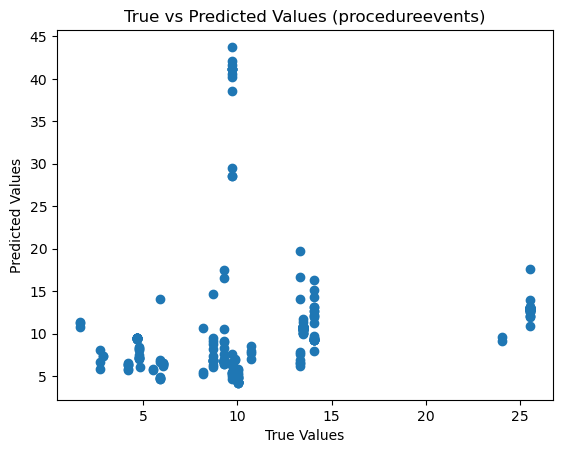

In [248]:
# Convert DataFrame to 1D array using ravel()
target = target.values.ravel()

# Predict on the test set
y_pred_procedure_events = random_forest_procedure_events.predict(data)

# Calculate mean squared error
mse = mean_squared_error(target, y_pred_procedure_events)
print("Mean Squared Error:", mse)

# Plot true vs predicted values
plt.scatter(target, y_pred_procedure_events)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (procedureevents)")
plt.show()

#### Compare to MSE of always guessing average

In [249]:
# Calculate the mean value of training set target variable
mean_prediction = np.mean(target)

# Generate an array of the same length as pred_values with the mean value
mean_guesses = np.full_like(target, mean_prediction)

# Calculate the Mean Squared Error (MSE) between the predicted values and the mean guesses
mse = np.mean((y_pred_procedure_events - mean_guesses) ** 2)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 54.7602816065825


#### Average prediction for each hadm_id

In [250]:
df_procedure_events_pred = pd.concat([df_procedure_events, pd.DataFrame(y_pred_procedure_events,columns=['prediction'])], axis=1)

In [251]:
predictions_procedure_events = pd.DataFrame()

In [252]:
predictions_procedure_events['prediction'] = df_procedure_events_pred.groupby('hadm_id')['prediction'].mean()
predictions_procedure_events = predictions_procedure_events.reset_index()

In [253]:
predictions_procedure_events

hadm_id  prediction
0   20297618    5.902666
1   21133938    7.947683
2   21255400    4.673227
3   21477991    6.424267
4   21607814   10.211452
5   22130791    9.435750
6   22490490    6.979523
7   22585261    6.860500
8   23488445    6.197971
9   24540843    7.859873
10  24656677    5.796567
11  25085565   13.824082
12  25922998    6.019086
13  26275841   38.532971
14  26842957   11.130004
15  27617929    7.623001
16  27660781    9.344571
17  27703517    9.196750
18  27993466    4.784895
19  28829452    7.098003
20  28998349   12.942012
21  29276678   10.659663
22  29279905    7.817047
23  29295881    7.329840
24  29974575   10.496204

In [254]:
# Have ended with a final prediction for a particular stay 

## Combining predictions

In [255]:
# LEFT OUT CHARTEVENTS FOR NOW

In [256]:
# predictions_poe_detail does not have hadm_id so merge with admissions on subject_id
path = "C:/Project/Data/"
file = "hosp/admissions.csv"
full_path = path + file

df_admissions = pd.read_csv(full_path)

In [257]:
df_selected = df_admissions[['hadm_id', 'subject_id']]

predictions_poe_detail = pd.merge(df_selected, predictions_poe_detail, on='subject_id', how='outer')

In [258]:
predictions_poe_detail = predictions_poe_detail.drop(columns=['subject_id'])

In [259]:
len(predictions_poe)

55

In [260]:
predictions_labevents = predictions_labevents.rename(columns={'prediction': 'labevents'})
predictions_microbio = predictions_microbio.rename(columns={'prediction': 'microbio'})
predictions_poe = predictions_poe.rename(columns={'prediction': 'poe'})
predictions_procedures = predictions_procedures.rename(columns={'prediction': 'procedures_icd'})
predictions_transfers = predictions_transfers.rename(columns={'prediction': 'transfers'})
predictions_input = predictions_input.rename(columns={'prediction': 'input'})
predictions_procedure_events = predictions_procedure_events.rename(columns={'prediction': 'procedure_events'})
predictions_poe_detail = predictions_poe_detail.rename(columns={'prediction': 'poe_detail'})

In [261]:
from functools import reduce

dfs = [predictions_labevents, predictions_microbio, predictions_poe, predictions_procedures, predictions_poe_detail,
                     predictions_transfers, predictions_input, predictions_procedure_events]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='hadm_id', how='outer'), dfs)


# merged_df = pd.merge(predictions_labevents, predictions_microbio, predictions_poe, predictions_procedures, 
#                      predictions_transfers, predictions_input, predictions_procedure_events, on='hadm_id', how='outer')
# merged_df = merged_df.fillna(0)

In [262]:
cleaned_df = merged_df.dropna(subset=['labevents', 'microbio', 'transfers', 'input','procedure_events',
                                     'poe', 'procedures_icd'], how='all')

In [263]:
cleaned_df.head()

hadm_id  labevents   microbio        poe  procedures_icd  poe_detail  \
0  20297618.0  14.076868  10.193954  12.022624       19.039440    8.261581   
1  20385771.0  20.516657  28.699598  15.001219       15.376163    9.660564   
2  20611796.0   7.117491        NaN   7.551078             NaN    8.261581   
3  21133938.0  11.506541   7.415772  12.154776       14.110954   10.092597   
4  21255400.0  12.124235  10.026562  11.196730       17.210178   10.137819   

   transfers     input  procedure_events  
0   9.952216  3.570473          5.902666  
1  24.680633       NaN               NaN  
2   4.987772       NaN               NaN  
3   9.088855  7.500904          7.947683  
4  10.099183  5.375197          4.673227

In [264]:
weights = [5,7,7,3,2,9,2,1] # change these
weights_df = pd.DataFrame(weights)

In [265]:
weights = {'labevents': 0.5, 'microbio': 0.7, 'transfers': 0.7, 'input': 0.3, 'procedure_events': 0.2, 
                  'poe': 0.9, 'poe_detail': 0.2,'procedures_icd': 0.1}

# # Define a function to calculate weighted average for each row
# def weighted_avg(row):
#     # Multiply each prediction by its corresponding weight, sum the results, and divide by the total weight
#     weighted_sum = sum(row[column] * weights[column] for column in cleaned_df.columns[1:])
#     total_weight = sum(weights.values())
#     return weighted_sum / total_weight

# # Apply the function to each row to calculate the weighted average
# cleaned_df['weighted_avg'] = cleaned_df.apply(weighted_avg, axis=1)


def weighted_avg(row):
    # Initialize variables to store the weighted sum and total weight
    weighted_sum = 0
    total_weight = 0
    # Iterate over each prediction column
    for column in cleaned_df.columns[1:]:
        # Check if the value is not NaN
        if not pd.isna(row[column]):
            # Add the weighted value to the sum and update the total weight
            weighted_sum += row[column] * weights[column]
            total_weight += weights[column]
    # Calculate the weighted average, handle division by zero if necessary
    if total_weight != 0:
        return weighted_sum / total_weight
    else:
        return np.nan  # Return NaN if total weight is zero

# Apply the function to each row to calculate the weighted average
cleaned_df['weighted_avg'] = cleaned_df.apply(weighted_avg, axis=1)

C:\Users\jenni\AppData\Local\Temp\ipykernel_21988\2313759328.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['weighted_avg'] = cleaned_df.apply(weighted_avg, axis=1)


In [266]:
cleaned_df.head()

hadm_id  labevents   microbio        poe  procedures_icd  poe_detail  \
0  20297618.0  14.076868  10.193954  12.022624       19.039440    8.261581   
1  20385771.0  20.516657  28.699598  15.001219       15.376163    9.660564   
2  20611796.0   7.117491        NaN   7.551078             NaN    8.261581   
3  21133938.0  11.506541   7.415772  12.154776       14.110954   10.092597   
4  21255400.0  12.124235  10.026562  11.196730       17.210178   10.137819   

   transfers     input  procedure_events  weighted_avg  
0   9.952216  3.570473          5.902666     10.491403  
1  24.680633       NaN               NaN     20.837199  
2   4.987772       NaN               NaN      6.738466  
3   9.088855  7.500904          7.947683      9.865342  
4  10.099183  5.375197          4.673227     10.145273

In [267]:
final_predictions = cleaned_df[['hadm_id','weighted_avg']].copy()

In [268]:
final_predictions = pd.merge(final_predictions, df_los_hadm, on='hadm_id', how='outer')

In [269]:
final_predictions = final_predictions.dropna(subset=['weighted_avg'], how='all')

In [270]:
final_predictions['los'] = final_predictions['los'].astype(str)
final_predictions['los'] = final_predictions['los'].apply(convert_to_days)

In [271]:
final_predictions.head()

hadm_id  weighted_avg        los
0  20297618.0     10.491403   9.720139
1  20385771.0     20.837199  23.683333
2  20611796.0      6.738466   2.719444
3  21133938.0      9.865342   8.688194
4  21255400.0     10.145273  10.003472

Mean Squared Error (MSE): 17.011570324003745
Root Mean Squared Error (RMSE): 4.124508494839566


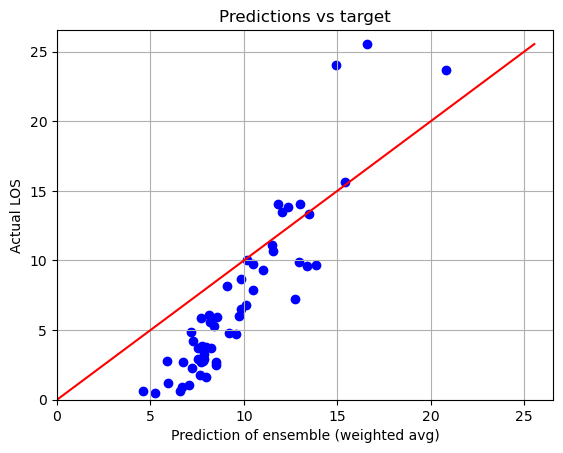

In [272]:
x = final_predictions['weighted_avg']
y = final_predictions['los']

plt.scatter(x, y, color='blue')
plt.xlabel('Prediction of ensemble (weighted avg)')
plt.ylabel('Actual LOS')
plt.title('Predictions vs target')
plt.grid(True)
# Set the limits of the plot manually to ensure the origin is (0,0)
plt.xlim(0, max(max(x), max(y))+1)
plt.ylim(0, max(max(x), max(y))+1)

# Plot y=x line in red
plt.plot([0, max(max(x), max(y))], [0, max(max(x), max(y))], color='red', label='y=x')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(x, y)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Show the plot
plt.show()

In [ ]:
# Good trend overall
# Has an offset and skew

In [277]:
merged_df = pd.merge(x, y, left_index=True, right_index=True)

# Calculate the absolute difference
merged_df['difference'] = abs(merged_df['weighted_avg'] - merged_df['los'])

# Count instances where the difference is less than or equal to 3
within_3_days_count = merged_df[merged_df['difference'] <= 3].shape[0]

# Calculate accuracy
total_instances = merged_df.shape[0]
accuracy = within_3_days_count / total_instances

print("Overall accuracy within 3 days:", accuracy)

Overall accuracy within 3 days: 0.36363636363636365


In [279]:
merged_df = pd.merge(x, y, left_index=True, right_index=True)

# Calculate the absolute difference
merged_df['difference'] = abs(merged_df['weighted_avg'] - merged_df['los'])

# Count instances where the difference is less than or equal to 7
within_3_days_count = merged_df[merged_df['difference'] <= 7].shape[0]

#Calculate accuracy
total_instances = merged_df.shape[0]
accuracy = within_3_days_count / total_instances

print("Overall accuracy within 7 days:", accuracy)

Overall accuracy within 7 days: 0.9636363636363636
